## Assessment 1: Deep Learning

1) Answer all questions.
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.
3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)
4) Upload the answer notebook to your github. 
5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a pretty girl who is choosing a dress for Hari Raya. It turns out that the girl is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue">
    The most suitable loss function for this AI system is Binary Cross Entropy Loss. The code in Python is torch.nn.BCELoss(). The loss function  is used to measuring a n error between 0 to 1. We can set the class of each cloth, abaya to class [0] and kebaya to class [1]. However, if feed with other than class 0 or 1, the loss function would be undefined. </span>

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    

<div>
<img src="https://vitalflux.com/wp-content/uploads/2021/11/VGG16-CNN-Architecture.png" width="550"/>
</div>


In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

transform = {
    'train': transforms.Compose([
        transforms.Resize(size=32),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=32),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.5,0.5,0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=32),
        transforms.Grayscale(num_output_channels=3),
        transforms.CenterCrop(size=32),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.5,0.5,0.5])
    ])
}
# Batch size
batch_size = 64
###### 1 #######/content/data/FashionMNIST
# Download Data from pytorch
trainset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST/', train=True,
                                        download=True, transform=transform['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST/', train=False,
                                       download=True, transform=transform['test'])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)                              
classes = ('T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')

In [3]:
# Number of classes
num_classes = len(classes)
print(num_classes)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

10
60000
10000


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

In [6]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        
            
    return model, history

In [7]:
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.7852, Accuracy: 70.1200%, 
		Validation : Loss : 0.5558, Accuracy: 79.2300%, Time: 50.2396s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.5635, Accuracy: 78.5667%, 
		Validation : Loss : 0.4672, Accuracy: 82.7600%, Time: 39.4295s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.5053, Accuracy: 80.7250%, 
		Validation : Loss : 0.4367, Accuracy: 83.0200%, Time: 38.7730s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4706, Accuracy: 82.1517%, 
		Validation : Loss : 0.4107, Accuracy: 84.6500%, Time: 38.0036s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4474, Accuracy: 83.1250%, 
		Validation : Loss : 0.4149, Accuracy: 84.6500%, Time: 38.4832s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.4263, Accuracy: 83.9333%, 
		Validation : Loss : 0.3709, Accuracy: 86.2800%, Time: 43.9530s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.4121, Accuracy: 84.4417%, 
		Validation : Loss : 0.3690, Accuracy: 86.6500%, Time: 40.6208s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3984, Accura

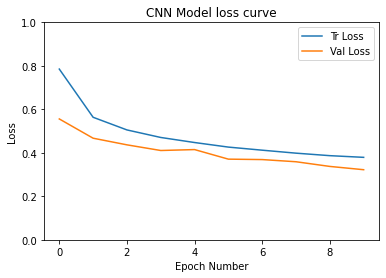

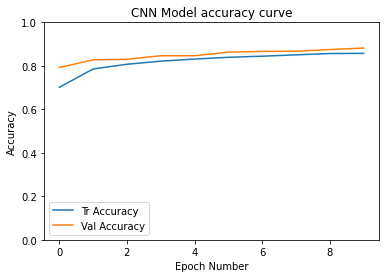

In [8]:
# 5. Analyze the loss curve

history = np.array(history)
plt.title('CNN Model loss curve')
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4],)
plt.title('CNN Model accuracy curve')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the', test_data_size, 'test images: ',100 * correct // total,' %')

Accuracy of the network on the 10000 test images:  88  %


c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [9]:
model_ft = models.shufflenet_v2_x1_0(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

In [10]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.9236, Accuracy: 66.1333%, 
		Validation : Loss : 9.5462, Accuracy: 67.3400%, Time: 70.5817s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.6588, Accuracy: 75.1383%, 
		Validation : Loss : 8.7710, Accuracy: 77.2300%, Time: 71.6600s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.6109, Accuracy: 77.2850%, 
		Validation : Loss : 7.1228, Accuracy: 78.9000%, Time: 70.4700s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.5912, Accuracy: 78.3383%, 
		Validation : Loss : 196280419.5511, Accuracy: 78.4600%, Time: 70.8641s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.5610, Accuracy: 79.5067%, 
		Validation : Loss : 0.5033, Accuracy: 81.9400%, Time: 69.3987s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.5701, Accuracy: 79.2467%, 
		Validation : Loss : 9925264475449.3301, Accuracy: 82.8100%, Time: 69.3987s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.5550, Accuracy: 80.2617%, 
		Validation : Loss : 24536.6550, Accuracy: 82.5300%, Time: 68.5116s
Epoch: 8/10
Epoch : 007, Traini

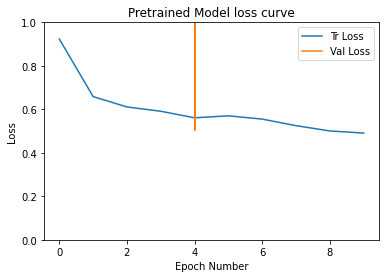

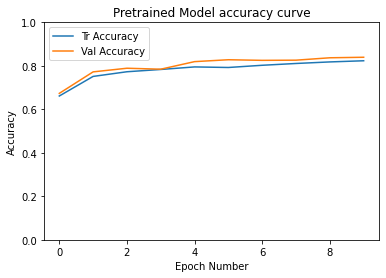

In [12]:
history = np.array(history)
plt.title('Pretrained Model loss curve')
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4],)
plt.title('Pretrained Model accuracy curve')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the', test_data_size, 'test images: ',100 * correct // total,' %')

Accuracy of the network on the 10000 test images:  83  %


In [24]:
new_model= models.googlenet(pretrained=True)
numFeatures= new_model.fc.in_features

for module, param in zip(new_model.modules(), new_model.parameters()):
    if isinstance(module,nn.BatchNorm2d):
        param.requires_grad=False
headmodel= nn.Sequential(nn.Linear(numFeatures,32),
                         nn.ReLU(),                         
                         nn.Linear(32,16),
                         nn.ReLU(),
                         nn.Linear(16,10))
new_model.fc = headmodel
new_model.to(device)
loss= nn.CrossEntropyLoss()
opt = optim.Adam(new_model.parameters(), lr= 0.001)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
num_epochs = 10
trained_model, history = train_and_validate(new_model, criterion, optimizer_ft, num_epochs)


Epoch: 1/10
Epoch : 000, Training: Loss: 2.3094, Accuracy: 10.3633%, 
		Validation : Loss : 2.3070, Accuracy: 11.3300%, Time: 78.9067s
Epoch: 2/10
Epoch : 001, Training: Loss: 2.3094, Accuracy: 10.5283%, 
		Validation : Loss : 2.3076, Accuracy: 10.5900%, Time: 75.5912s
Epoch: 3/10
Epoch : 002, Training: Loss: 2.3095, Accuracy: 10.3333%, 
		Validation : Loss : 2.3083, Accuracy: 10.6200%, Time: 75.6625s
Epoch: 4/10
Epoch : 003, Training: Loss: 2.3092, Accuracy: 10.4850%, 
		Validation : Loss : 2.3082, Accuracy: 10.5200%, Time: 76.7172s
Epoch: 5/10
Epoch : 004, Training: Loss: 2.3090, Accuracy: 10.5967%, 
		Validation : Loss : 2.3079, Accuracy: 10.9300%, Time: 77.4779s
Epoch: 6/10
Epoch : 005, Training: Loss: 2.3094, Accuracy: 10.4150%, 
		Validation : Loss : 2.3087, Accuracy: 11.2600%, Time: 75.2164s
Epoch: 7/10
Epoch : 006, Training: Loss: 2.3094, Accuracy: 10.3950%, 
		Validation : Loss : 2.3084, Accuracy: 10.8500%, Time: 74.8739s
Epoch: 8/10
Epoch : 007, Training: Loss: 2.3096, Accura

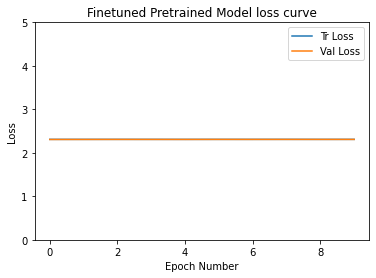

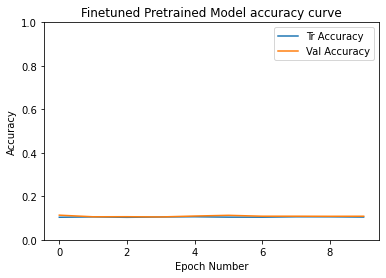

In [26]:
history = np.array(history)
plt.title('Finetuned Pretrained Model loss curve')
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,5)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4],)
plt.title('Finetuned Pretrained Model accuracy curve')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [27]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = new_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the', test_data_size, 'test images: ',100 * correct // total,' %')

Accuracy of the network on the 10000 test images:  10  %


d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
    Two model-centric techniques that I propose are:
    1. Add dropout after convolutional layers 
         2. Adding skip connections to the CNN. </span>

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [30]:
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

#Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
print(num_ftrs)
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, (num_ftrs//2)),nn.ReLU(),
                            nn.Linear((num_ftrs//2), (num_ftrs//4)), nn.ReLU(),
                            nn.Linear((num_ftrs//4), (num_ftrs//8)), nn.ReLU(),
                            nn.Linear((num_ftrs//8), (num_ftrs//16)), nn.ReLU(),
                            nn.Linear((num_ftrs//16), len(classes))
                            )

model = model_conv.to(device)
loss= nn.CrossEntropyLoss()
opt = optim.Adam(model_conv.parameters(), lr= 0.001)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512


In [31]:
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 2.3044, Accuracy: 10.0267%, 
		Validation : Loss : 2.3049, Accuracy: 9.9800%, Time: 60.6508s
Epoch: 2/10
Epoch : 001, Training: Loss: 2.3045, Accuracy: 10.0100%, 
		Validation : Loss : 2.3046, Accuracy: 10.0000%, Time: 60.7272s
Epoch: 3/10
Epoch : 002, Training: Loss: 2.3044, Accuracy: 10.0133%, 
		Validation : Loss : 2.3047, Accuracy: 9.9900%, Time: 60.6209s
Epoch: 4/10
Epoch : 003, Training: Loss: 2.3045, Accuracy: 10.0083%, 
		Validation : Loss : 2.3046, Accuracy: 9.9900%, Time: 59.7141s
Epoch: 5/10
Epoch : 004, Training: Loss: 2.3044, Accuracy: 10.0150%, 
		Validation : Loss : 2.3047, Accuracy: 9.9800%, Time: 62.7495s
Epoch: 6/10
Epoch : 005, Training: Loss: 2.3044, Accuracy: 10.0067%, 
		Validation : Loss : 2.3048, Accuracy: 9.9600%, Time: 67.5350s
Epoch: 7/10
Epoch : 006, Training: Loss: 2.3043, Accuracy: 10.0367%, 
		Validation : Loss : 2.3044, Accuracy: 9.9900%, Time: 60.5401s
Epoch: 8/10
Epoch : 007, Training: Loss: 2.3044, Accuracy: 10

In [32]:
seed = 172
torch.manual_seed(seed)

class SkipConnection(nn.Module):

    def __init__(self):
        super(SkipConnection, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 6, 2, stride=2, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv_layer2 = nn.Conv2d(6, 10, 2, stride=2, padding=2)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, input: torch.FloatTensor) -> torch.FloatTensor:
        x = self.conv_layer1(input)
        x = self.relu(x)
        x = self.conv_layer2(x)
        x = self.relu2(x)
        return x + input

skip_model = SkipConnection()
skip_model.to(device)
loss= nn.CrossEntropyLoss()
opt = optim.Adam(model_conv.parameters(), lr= 0.001)

In [ ]:
num_epochs = 10
trained_model, history = train_and_validate(skip_model, criterion, optimizer_ft, num_epochs)

f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
    THe results were not improving after training with Pretrained model. This is because I change the learning rate to be higher and batch size to be bigger to save time on training.  </span>

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue">
     1. We can expand the dataset by making image augmentations to the images in the datasets. This makes the neural network to be more exposed to the variations in lighting and orientations.
    2. We also can clean the datasets by removing the unwanted and unrelated noise in the dataset. This is done so that the neural network will not be making false prediction between 2 different classes.  </span>

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [38]:
image_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=32), #resizing
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(), #Random Horizontal Flipping
        transforms.CenterCrop(size=32), #Center Cropping
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.5,0.5,0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=32),
        transforms.Grayscale(num_output_channels=3),
        transforms.CenterCrop(size=32),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.5,0.5,0.5])
    ])
}

We can clean the dataset by removing unrelated images from the dataset by manually scanning image by image and delete unwanted images. However, some noise need to be kept to ensure the model is robus and can perform in different situatuions.

**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="TcG4jJqxYwp2zIfEtgyh")
project = rf.workspace("iium-1mzmy").project("assessment-1")
dataset = project.version(2).download("yolov5")

In [41]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12351, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 12351 (delta 86), reused 95 (delta 51), pack-reused 12209
Receiving objects: 100% (12351/12351), 12.41 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (8448/8448), done.
/content/yolov5
Setup complete. Using torch 1.12.0+cu113 (Tesla T4)


In [42]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [43]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [44]:
from roboflow import Roboflow
rf = Roboflow(api_key="TcG4jJqxYwp2zIfEtgyh")
project = rf.workspace("iium-1mzmy").project("assessment-1")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/assessment-1-2 in yolov5pytorch:: 100%|██████████| 1066/1066 [00:00<00:00, 1264.77it/s]


In [45]:
!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/assessment-1-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-347-g7b9cc32 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_

In [46]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/shafiq.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --source /content/test.mp4

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/test.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-347-g7b9cc32 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/587) /content/test.mp4: 384x640 2 shafiqs, Done. (0.013s)
video 1/1 (2/587) /content/test.mp4: 384x640 2 shafiqs, Done. (0.011s)
video 1/1 (3/587) /content/test.mp4: 384x640 2 shafiqs, Done. (0.011s)
video 1/1 (4/587) /content/test.mp4: 384x640 2 shafiqs, Done. (0.011s)
video 1/1 (5/587) /content/test.mp4: 384x640 1 others, 2 shafi